# Min-min Max-max

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [85]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [86]:
df_train_X = pd.read_csv('../Data/train_data.csv')
df_train_Y = pd.read_csv('../Data/train_answers.csv')

In [87]:
df_test = pd.read_csv('../Data/test_data.csv')

In [88]:
X_pred = df_train_X.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                           'Ymin': [min, max, 'mean', 'std', 'median'],
                                           'Xmax': [min, max, 'mean', 'std', 'median'],
                                           'Ymax': [min, max, 'mean', 'std', 'median'],
                                           'userId': 'count'})

In [89]:
X_pred = X_pred.merge(df_train_Y, on='itemId', how='inner')

In [90]:
X_pred["iou"] = X_pred[[('Xmin', 'min'),('Ymin', 'min'), ('Xmax', 'max'), ('Ymax', 'max'), 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [91]:
X_pred['iou'].mean()

0.5809800227327839

### Прогнозирование отклонения

In [92]:
X_pred['Volume'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]) *\
                    (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['X_Y_ratio'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')])/\
                            (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['X_length'] = X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]
X_pred['Y_length'] = X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')]


In [93]:
X_pred['X_Y_ratio'] = X_pred['X_Y_ratio'].replace(np.inf, 2)
X_pred.fillna(1, inplace=True)

In [94]:
Xmin_dtarg = X_pred['Xmin_true'] - X_pred[('Xmin', 'min')]
Ymin_dtarg = X_pred['Ymin_true'] - X_pred[('Ymin', 'min')]
Xmax_dtarg = X_pred['Xmax_true'] - X_pred[('Xmax', 'max')]
Ymax_dtarg = X_pred['Ymax_true'] - X_pred[('Ymax', 'max')]

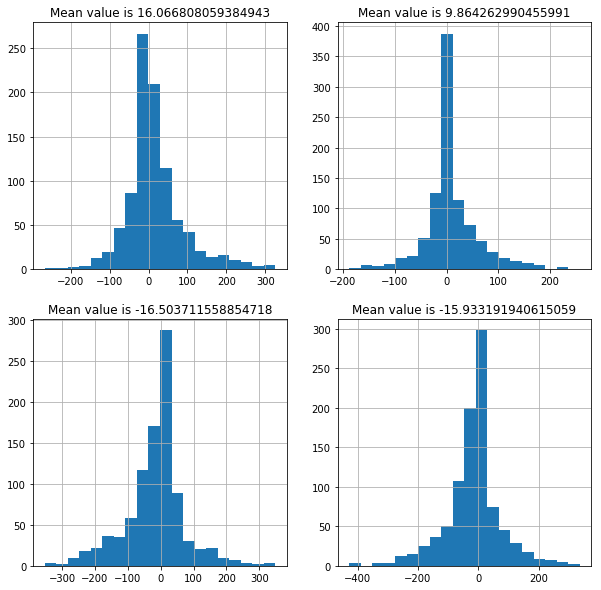

In [95]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
Xmin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmin_dtarg.mean()));

plt.subplot(2, 2, 2)
Ymin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymin_dtarg.mean()));

plt.subplot(2, 2, 3)
Xmax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmax_dtarg.mean()));

plt.subplot(2, 2, 4)
Ymax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymax_dtarg.mean()));

Качество, если добавить константы отклонений к прогнозам

In [96]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,"(userId, count)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,X_Y_ratio,X_length,Y_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,3,198,827,649,1340,0.520083,150120,0.863309,360,417
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,3,26,605,433,847,0.723581,106145,1.187291,355,299
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,3,233,698,622,920,0.392782,219075,1.509186,575,381
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,5,61,368,329,530,0.673495,35742,1.876812,259,138
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,6,30,536,328,813,0.359999,229295,0.626446,379,605


In [97]:
train_data = X_pred.drop(columns=['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'], axis=1)

In [111]:
train_data.columns

Index([    ('Xmin', 'min'),     ('Xmin', 'max'),    ('Xmin', 'mean'),
           ('Xmin', 'std'),  ('Xmin', 'median'),     ('Ymin', 'min'),
           ('Ymin', 'max'),    ('Ymin', 'mean'),     ('Ymin', 'std'),
        ('Ymin', 'median'),     ('Xmax', 'min'),     ('Xmax', 'max'),
          ('Xmax', 'mean'),     ('Xmax', 'std'),  ('Xmax', 'median'),
           ('Ymax', 'min'),     ('Ymax', 'max'),    ('Ymax', 'mean'),
           ('Ymax', 'std'),  ('Ymax', 'median'), ('userId', 'count'),
                  'Volume',         'X_Y_ratio',          'X_length',
                'Y_length'],
      dtype='object')

### Random Forest

In [98]:
model_Xmin = RandomForestRegressor(n_estimators=500)
preds_Xmin = cross_val_predict(model_Xmin, train_data, Xmin_dtarg, cv=4, n_jobs=-1)

In [99]:
model_Ymin = RandomForestRegressor(n_estimators=500)
preds_Ymin = cross_val_predict(model_Ymin, train_data, Ymin_dtarg, cv=4, n_jobs=-1)

In [100]:
model_Xmax = RandomForestRegressor(n_estimators=500)
preds_Xmax = cross_val_predict(model_Xmax, train_data, Xmax_dtarg, cv=4, n_jobs=-1)

In [101]:
model_Ymax = RandomForestRegressor(n_estimators=500)
preds_Ymax = cross_val_predict(model_Ymax, train_data, Ymax_dtarg, cv=4, n_jobs=-1)

### Score

In [102]:
X_rez = X_pred.copy()

In [103]:
X_rez['Xmin_pred'] = X_rez[('Xmin', 'min')] + preds_Xmin/3
X_rez['Ymin_pred'] = X_rez[('Ymin', 'min')] + preds_Ymin/3
X_rez['Xmax_pred'] = X_rez[('Xmax', 'max')] + preds_Xmax/3
X_rez['Ymax_pred'] = X_rez[('Ymax', 'max')] + preds_Ymax/3


X_rez["iou"] = X_rez[['Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [104]:
X_rez['iou'].mean()

0.582381795168581

### Train models on whole data

In [105]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmin_dtarg)

model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymin_dtarg)

model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmax_dtarg)

model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymax_dtarg)

## Test dataset preparation

In [116]:
X_test = df_test.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                        'Ymin': [min, max, 'mean', 'std', 'median'],
                                        'Xmax': [min, max, 'mean', 'std', 'median'],
                                        'Ymax': [min, max, 'mean', 'std', 'median'],
                                        'userId': 'count'})

In [117]:
X_test['Volume'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]) *\
                    (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])

X_test['X_Y_ratio'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')])/\
                            (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])    
    
X_test['X_length'] = X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]
X_test['Y_length'] = X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')]

In [118]:
X_test['X_Y_ratio'] = X_test['X_Y_ratio'].replace(np.inf, 2)
X_test.fillna(1, inplace=True)

In [119]:
preds_Xmin = model_Xmin.predict(X_test)
preds_Ymin = model_Ymin.predict(X_test)
preds_Xmax = model_Xmax.predict(X_test)
preds_Ymax = model_Ymax.predict(X_test)

In [120]:
X_test['Xmin_pred'] = X_test[('Xmin', 'min')] + preds_Xmin/3
X_test['Ymin_pred'] = X_test[('Ymin', 'min')] + preds_Ymin/3
X_test['Xmax_pred'] = X_test[('Xmax', 'max')] + preds_Xmax/3
X_test['Ymax_pred'] = X_test[('Ymax', 'max')] + preds_Ymax/3

In [121]:
X_test['itemId'] = X_test.index
X_test = X_test[['itemId', 'Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred']]

In [122]:
X_test.to_csv('../Submits/submit9.csv', header=False, index=False)

In [123]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,"(userId, count)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,X_Y_ratio,X_length,Y_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,3,198,827,649,1340,0.520083,150120,0.863309,360,417
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,3,26,605,433,847,0.723581,106145,1.187291,355,299
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,3,233,698,622,920,0.392782,219075,1.509186,575,381
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,5,61,368,329,530,0.673495,35742,1.876812,259,138
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,6,30,536,328,813,0.359999,229295,0.626446,379,605


In [113]:
X_test.head()

Xmin                               Ymin                                 \
        min  max        mean         std   min   max         mean         std   
itemId                                                                          
18      126  144  135.000000   12.727922   634   774   704.000000   98.994949   
19       27   34   29.666667    3.785939   559   564   560.666667    2.886751   
33       21   75   46.333333   27.153882   380   413   393.666667   17.214335   
62       35  125   90.857143   30.514633   824  1054   964.857143   69.681247   
114      41   80   63.333333   20.108042   570   580   575.000000    5.000000   
146      17  120   72.000000   33.645208   211   757   481.375000  269.746409   
156      74   92   84.333333    9.291573   802   812   805.333333    5.773503   
163      21   56   33.333333   11.792653   317   327   322.166667    3.600926   
164       4   18    9.333333    7.571878   146   151   148.666667    2.516611   
179     116  135  126.000000    9.539392   490   532   512.333333   21.126603   
186      82  456  233.857143  148.066909   890  1160   975.142857  101.987628   
215     228  306  259.666667   41.016257   639   678   660.000000   19.672316   
225      39   57   45.875000    6.446206   705   713   708.375000    2.503569   
227     216  394  306.800000   75.390318   841   922   880.800000   37.917015   
247      46   69   57.250000    7.401737   623   640   630.500000    6.071008   
275      19  322  113.142857   99.529608   466   621   522.428571   47.465276   
311      94  261  191.100000   46.829359   593   658   625.100000   22.178318   
399      79  272  136.166667   71.981711   746   850   802.166667   35.846432   
421      50   70   56.500000    7.176350   932   942   935.500000    3.834058   
432      52  113   73.666667   34.122329   840   849   845.000000    4.582576   
442      33   54   40.666667   11.590226   672   674   673.333333    1.154701   
459      19   21   20.000000    1.000000   336   339   337.666667    1.527525   
492      90  209  134.333333   65.041013  1089  1104  1095.333333    7.767453   
507     152  912  295.333333  234.326695   220   309   250.444444   33.886248   
631     178  302  246.333333   62.962952   568   634   591.666667   36.746882   
707      44   55   48.166667    4.167333   814   823   818.666667    3.444803   
723      76  316  154.714286   83.424046   156   263   193.428571   42.185531   
1003     48  166  111.000000   39.832985   603   624   614.000000    7.211103   
1065     61  342  165.600000  105.854407   854   934   876.300000   21.914227   
1136    240  345  276.571429   36.454799   791   925   875.000000   42.782395   
...     ...  ...         ...         ...   ...   ...          ...         ...   
34122   209  218  214.333333    4.725816   317   344   328.000000   14.177447   
34143    59  270  128.142857   81.120134   587   669   625.571429   30.423988   
34284    35  399  100.111111  116.066193   636   760   682.555556   40.951530   
34340    46  135   78.000000   49.487372   677   683   679.333333    3.214550   
34455    42  147  110.000000   58.966092   351   361   355.666667    5.033223   
34465    42  147   97.333333   52.728866   312   345   327.333333   16.623277   
34471    50  135   70.200000   36.690598   736   811   760.000000   30.356218   
34483    56  214  173.000000   62.539587  1182  1255  1225.166667   32.251615   
34652   118  171  144.333333   26.501572   882   939   914.333333   29.263174   
34655    52  204  156.625000   62.757896  1314  1331  1323.625000    6.116430   
34796    42   64   54.375000    7.576986   427   448   438.000000    7.483315   
34804    85   86   85.333333    0.577350   640   655   647.666667    7.505553   
34958   190  447  320.625000   77.573813   201   286   247.875000   28.925705   
35020    57   85   71.666667   14.047538   140   192   173.000000   28.687977   
35021    36   47   41.666667    5.507571   438   443   440.000000    2.645751   
35110    62  219  169.333333   55.7625

## Test prediction

In [18]:
test_pred = df_test.groupby('itemId').agg({'Xmin': min,
                                              'Ymin': min,
                                              'Xmax': max,
                                              'Ymax': max})

In [29]:
test_pred['itemId'] = test_pred.index
test_pred = test_pred[['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]

In [30]:
test_pred.to_csv('../Submits/submit3.csv', header=False, index=False)

In [31]:
test_pred

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,126,634,764,1132
19,19,27,559,119,729
33,33,21,380,414,652
62,62,35,824,639,1262
114,114,41,570,216,780
146,146,17,211,643,1118
156,156,74,802,160,887
163,163,21,317,213,465
164,164,4,146,401,681
